# Определение выгодного тарифа для телеком компании

На данных федерального оператора сотовой связи мы определим, какой из двух тарифных планов приносит больше денег. Это позволит коммерческому департаменту телеком-компании скорректировать рекламный бюджет.

**Задача исследования**

Определить более выгодный для компании тариф.

**Описание тарифов**

|Тариф|Ежемесячная плата|Включено в тариф|Стоимость сверх пакета|
|:--  |:--              |:--             |:--                   |
|«Смарт»|550 руб.|500 мин.<br />50 сообщений<br />15 Гб|3 руб./мин.<br />3 руб./сообщение<br />200 руб./Гб|
|«Ультра»|1950 руб.|3000 мин.<br />1000 сообщений<br />30 Гб|1 руб./мин.<br />1 руб./сообщение<br /> 150 руб./Гб|

Для звонков производится округление до минут в большую сторону. Каждый звонок округляется отдельно.

Для веб-трафика производится округление до Гб в большую сторону. Отдельные сессии не считаются, округляется общая сумма Мб за месяц.

**Ход исследования**

В файлах содержатся данные 500 пользователей федерального оператора сотовой связи:

  * `data_calls.csv`: информация о звонках
  * `data_internet.csv`: информация об интернет-сессиях
  * `data_messages.csv`: информация о сообщениях
  * `data_tariffs.csv`: информация о тарифах
  * `data_users.csv`: информация о пользователях

Поскольку данные представлены в нескольких файлах, перед проведением исследования их потребуется объединить. Перед решением задачи исследования понадобится обзор данных. Затем, на этапе предобработки, поищем возможность исправить самые критичные ошибки данных.

Для решения задачи исследования необходимо рассчитать и добавить в таблицу несколько показателей:

  * количество сделанных звонков и израсходованных минут разговора по месяцам;
  * количество отправленных сообщений по месяцам;
  * объем израсходованного интернет-трафика по месяцам;
  * помесячную выручку с каждого пользователя.

Для определить более выгодного тарифа потребуется:

  * изучить поведение пользователей:
    1. Сколько минут разговора требуется пользователям каждого тарифа в месяц?
    2. Сколько сообщений требуется пользователям каждого тарифа в месяц?
    3. Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
  * проверить гипотезы:
    1. Средняя выручка пользователей тарифов «Смарт» и «Ультра» различаются;
    2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Таким образом, **исследование пройдёт в четыре этапа**:

  1. Обзор данных.
  2. Предобработка данных.
  3. Расчёты и добавление результатов в таблицу.
  4. Статистический анализ данных.

## Обзор данных
Составим первое впечатление о входных данных.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st 

In [2]:
# Прочитаем и выведем как датафреймы все полученные файлы

# Список названий файлов
filenames = ['calls', 'internet', 'messages', 'tariffs', 'users']

# Пустой список для сохранения датафреймов
temp_dataframes = []

# Читаем файлы и записываем датафреймы в список
for filename in filenames:
    temp_df = pd.read_csv('data_' + filename + '.csv')
    temp_dataframes.append(temp_df)

In [3]:
# Обзор датафрейма calls, получаем общую информацию
calls = temp_dataframes[0]
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В таблице 202 607 записей о звонках пользователей, пропусков в данных нет.

Согласно документации к данным:

  * `id` — уникальный номер звонка
  * `call_date` — дата звонка
  * `duration` — длительность звонка в минутах
  * `user_id` — идентификатор пользователя, сделавшего звонок

Отмечено несоответствие типа данных документации:

  * `id`: строка object, по документации номер → не будем менять тип данных, поскольку столбец не имеет значения для исследования
  * `call_date`: строка `object`, по документации дата → `datetime`
  * `duration`: вещественное число `float64`. По условиям тарифов каждый звонок округляется до минут в большую сторону, поэтому значения должны быть целочисленными → `int64`

In [4]:
# Обзор датафрейма calls, получаем описательную статистику числовых столбцов
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


В столбце `duration` есть нулевые значения. Согласно сопроводительной документации, нулями обозначены пропущенные звонки, поэтому их удаление приведет к потере данных о количестве звонков. Представлены значения `user_id` от 1000 до 1499.

In [5]:
# Обзор датафрейма internet, получаем общую информацию
internet = temp_dataframes[1]
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице 149 396 записей об интернет-сессиях пользователей, пропусков в данных нет.

Согласно документации к данным:

  * `id` — уникальный номер сессии
  * `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
  * `session_date` — дата интернет-сессии
  * `user_id` — идентификатор пользователя

Отмечено несоответствие типа данных документации:

  * `id`: строка object, по документации номер → не будем менять тип данных, поскольку столбец не имеет значения для исследования
  * `session_date`: строка `object`, по документации дата → `datetime`

In [6]:
# Обзор датафрейма internet, получаем описательную статистику числовых столбцов
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


В результате чтения из файла появился лишний столец с индексами `Unnamed: 0`. Необходимости удалять его нет, поскольку данные из таблицы в исследовании будут использованы частично. Представлены значения `user_id` от 1000 до 1499.

In [7]:
# Обзор датафрейма messages, получаем общую информацию
messages = temp_dataframes[2]
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В таблице 123 036 записей о сообщениях пользователей, пропусков в данных нет.

Согласно документации к данным:

  * `id` — уникальный номер сообщения
  * `message_date` — дата сообщения
  * `user_id` — идентификатор пользователя, отправившего сообщение

Отмечено несоответствие типа данных документации:

  * `id`: строка object, по документации номер → не будем менять тип данных, поскольку столбец не имеет значения для исследования
  * `message_date`: строка object, по документации дата → `datetime`

In [8]:
# Обзор датафрейма messages, получаем описательную статистику числовых столбцов
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


Представлены значения `user_id` от 1000 до 1499.

In [9]:
# Обзор датафрейма tariffs, получаем общую информацию
tariffs = temp_dataframes[3]
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице 2 записи с характеристиками тарифов «Смарт» и «Ультра».

Согласно документации к данным:

  * `tariff_name` — название тарифа
  * `rub_monthly_fee` — ежемесячная абонентская плата в рублях
  * `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
  * `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
  * `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
  * `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
  * `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
  * `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [10]:
# Обзор датафрейма users, получаем общую информацию
users = temp_dataframes[4]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице 500 записей с данными пользователей, пропуски присутствуют в столбце `churn_date`.

Согласно документации к данным:

  * `user_id` — уникальный идентификатор пользователя
  * `first_name` — имя пользователя
  * `last_name` — фамилия пользователя
  * `age` — возраст пользователя (годы)
  * `reg_date` — дата подключения тарифа (день, месяц, год)
  * `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
  * `city` — город проживания пользователя
  * `tariff` — название тарифного плана

Отмечено несоответствие типа данных документации:

  * `churn_date`: строка object, по документации дата → не будем менять тип данных, поскольку столбец не имеет значения для исследования
  * `reg_date`: строка object, по документации дата → не будем менять тип данных, поскольку столбец не имеет значения для исследования

Судя по документации, пропуски в столбце `churn_date` ошибкой не являются.

In [11]:
# Обзор датафрейма users, получаем описательную статистику числовых столбцов
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Представлены значения `user_id` от 1000 до 1499. Аномалий в столбце `age` не обнаружено.

**Вывод**

Как и следовало из сопроводительной информации и документации, в исходных файлах содержатся данные 500 пользователей телеком-оператора, их личные данные, звонки, сообщения и интернет-сессии. Отдельно представлена таблица с параметрами двух тарифов.

Столбцы с датой в датафреймах `calls`, `internet`, `messages` приведем к типу datetime. Тип данных столбца `duration` датафрейма `calls` заменим на целочисленный, предварительно округлив в большую сторону.

Для решения задачи исследования имеющихся данных недостаточно, потребуется выполнить расчеты и внести данные в таблицу.

## Предобработка данных
Проведем замену типов данных.

### Замена типа данных
Обработаем столбцы `call_date`, `session_date`, `message_date` в датафреймах `calls`, `internet`, `messages`. Изменим название столбцов на `date` и заменим тип данных на дату с помощью функции `pandas.to_datetime`. Обработаем столбец `duration` датафрейма `calls`. Округлим значения в большую сторону и заменим тип данных на целочисленный с помощью функции `pandas.DataFrame.astype`.

In [12]:
# Переименуем столбцы
calls = calls.rename(
    columns={'id': 'id',
             'call_date': 'date',
             'duration': 'duration',
             'user_id': 'user_id'}
)
internet = internet.rename(
    columns={'id': 'id',
             'mb_used': 'mb_used',
             'session_date': 'date',
             'user_id': 'user_id'}
)
messages = messages.rename(
    columns={'id': 'id',
             'message_date': 'date',
             'user_id': 'user_id'}
)

# Список датафреймов для обработки
dataframes = [calls, internet, messages]

# Изменим тип данных на datetime
for dataframe in dataframes:
    dataframe['date'] = pd.to_datetime(
        dataframe['date'], format='%Y-%m-%d'
    )

In [13]:
# Округлим и изменим тип данных в столбце duration
calls['duration'] = (
    np.ceil(calls['duration']).astype('int64')
)

In [14]:
# Проверим изменение типа данных
for dataframe in dataframes:
    print(dataframe.dtypes)
    print()

calls.head()

id                  object
date        datetime64[ns]
duration             int64
user_id              int64
dtype: object

Unnamed: 0             int64
id                    object
mb_used              float64
date          datetime64[ns]
user_id                int64
dtype: object

id                 object
date       datetime64[ns]
user_id             int64
dtype: object



,id,date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


**Вывод**

Для столбцов `call_date`, `session_date`, `message_date` в датафреймах `calls`, `internet`, `messages` тип данных изменен на `datetime`.

Для столбца `duration` датафрейма `calls` проведено округление и заменен тип данных на целочисленный.

## Расчёты и добавление результатов в таблицу
Расчитаем данные, которые потребуются для решения задач исследования:

  * количество сделанных звонков по месяцам из датафрейма `calls`
  * количество израсходованных минут разговора по месяцам из датафрейма `calls`
  * количество отправленных сообщений по месяцам из датафрейма `messages`
  * объем израсходованного интернет-трафика по месяцам из датафрейма `internet`
  * помесячная выручка с каждого пользователя рассчитаем в общем датафрейме
  
Для расчета данных по месяцам добавим столбец `month`, хранящий информацию о месяце, в котором совершена операция (звонок, сообщение, интернет-сессия) в датафреймы `calls`, `messages`, `internet`. Затем сгруппируем данные по пользователям и месяцам и объединим датафреймы в общий с помощью общих столбцов `user_id` и `month`.

Для расчета выручки по месяцам добавим в общий датафрейм информацию о тарифе пользователя из датафрейма `users` по общему столбцу `user_id` и добавим параметры тарифов из датафрейма `tariffs` по столбцам `tariff` и `tariff_name`.

In [15]:
# Список датафреймов для обработки
dataframes = [calls, internet, messages]

# Добавляем столбцы month
for dataframe in dataframes:
    dataframe['month'] = dataframe['date'].dt.month

### Количество звонков и минут

In [16]:
# Создадим общий датафрейм df
# Рассчитаем и добавим количество звонков и минут
df = (
    calls.groupby(['user_id', 'month'])
    .agg({'id': 'count', 'duration': 'sum'})
    .reset_index()
)

### Количество сообщений

In [17]:
# Рассчитаем количество сообщений
# Присоединим данные к общему датафрейму
df = df.merge(
    messages.groupby(['user_id', 'month'])
    .agg({'id': 'count'}),
    on=['user_id', 'month'],
    how='outer'
)

### Объем интернет-трафика

In [18]:
# Рассчитаем интернет-трафика
# Присоединим данные к общему датафрейму
df = df.merge(
    internet
    .groupby(['user_id', 'month'])
    .agg({'mb_used': 'sum'}),
    on=['user_id', 'month'],
    how='outer'
)

### Помесячная выручка

In [19]:
# Заменим пропуски в общем датафрейме на нули
df.fillna(0, inplace=True)

In [20]:
# Расширим общий датафрейм информацией о пользователях
df = df.merge(users[['user_id', 'city', 'tariff']], on='user_id', how='left')

In [21]:
# Переименуем столбцы датафрейма df
df = df.rename(
    columns={'id_x': 'calls',
             'duration': 'total_duration',
             'id_y': 'messages'}
)

In [22]:
# Расширим общий датафрейм параметрами тарифа
df = df.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')

Для расчета помесячной выручки с каждого пользователя вычтем бесплатные лимиты из суммарного времени звонков, количества сообщений и интернет-трафика. Остаток умножим на значения из тарифного плана и прибавим абонентскую плату по тарифу.

Если израсходовано меньше минут (сообщений, интернет-трафика), чем было в пакете, подставим в формулу расчета доплаты ноль.

По условиям тарифов, общая сумма Мб интернет-трафика за месяц округляется до Гб в большую сторону. Для расчета расходования пакета Гб по тарифу, разделим количество использованных Мб интернет-трафика на 1024 и округлим вверх до целого числа.

In [23]:
# Добавим столбец с помесячной выручкой с каждого пользователя
df['earnings'] = (
    np.maximum((df['total_duration'] - df['minutes_included']), 0)
    * df['rub_per_minute']
    + np.maximum((df['messages'] - df['messages_included']), 0)
    * df['rub_per_message']
    + (np.maximum((df['mb_used'] - df['mb_per_month_included']), 0)
    / 1024).apply(np.ceil) * df['rub_per_gb']
    + df['rub_monthly_fee']
)

In [24]:
# Проверим получившуюся таблицу, выведем 5 случайных строк
df.sample(5)

,user_id,month,calls,total_duration,messages,mb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,earnings
1027,1165,11,34.0,232.0,197.0,42144.47,Самара,ultra,1000,30720,3000,1950,150,1,1,ultra,3750.0
517,1082,10,32.0,303.0,73.0,10968.32,Москва,smart,50,15360,500,550,200,3,3,smart,619.0
778,1123,10,89.0,591.0,17.0,18245.45,Краснодар,smart,50,15360,500,550,200,3,3,smart,1423.0
1830,1292,7,29.0,206.0,0.0,39969.13,Красноярск,ultra,1000,30720,3000,1950,150,1,1,ultra,3450.0
1550,1248,10,113.0,727.0,0.0,21007.90,Москва,smart,50,15360,500,550,200,3,3,smart,2431.0


**Вывод**

Для проведения статистического анализа данных собран датафрейм со всеми активными за период пользователями. Для каждого пользователя есть помесячные данные о количество сделанных звонков, израсходованных минут, отправленных сообщений, израсходованного интернет-трафика. Рассчитана помесячная выручка с каждого пользователя.

## Статистический анализ

### Анализ поведения клиентов
Исходя из выборки в 500 пользователей, опишем поведение клиентов телеком-оператора.

#### Сколько минут разговора требуется пользователям каждого тарифа в месяц?

In [25]:
# Рассчитаем среднее, дисперсию и стандартное отклонение
(
    df.groupby('tariff')
    .agg({'total_duration': ['mean', 'var', 'std']})
    .round()
)

total_duration                 
                 mean       var    std
tariff                                
smart           418.0   36219.0  190.0
ultra           527.0  100874.0  318.0

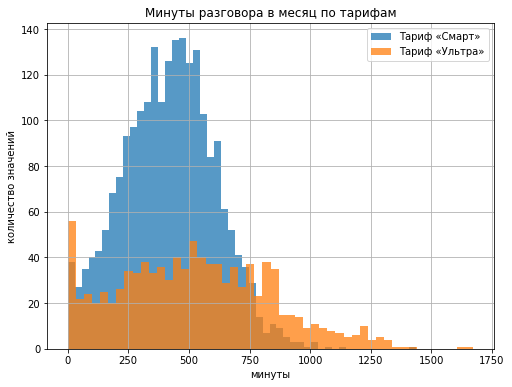

In [26]:
# Построим гистограмму
(
    df.query('tariff == "smart"')['total_duration']
    .hist(bins=50, alpha=0.75, figsize=(8, 6))
)
(
    df.query('tariff == "ultra"')['total_duration']
    .hist(bins=50, alpha=0.75, figsize=(8, 6))
)
plt.title('Минуты разговора в месяц по тарифам')
plt.xlabel('минуты')
plt.ylabel('количество значений')
plt.legend(['Тариф «Смарт»', 'Тариф «Ультра»'])
plt.show()

In [27]:
# Посчитаем предельные значения по правилу трех сигм
print('Тариф «Смарт»:', 418 + 3 * 190)
print('Тариф «Ультра»:', 527 + 3 * 318)

Тариф «Смарт»: 988
Тариф «Ультра»: 1481


Гистограммма тяготеет к нормальному распределению. Особенно это заметно для тарифа «Смарт», им пользуется большинство клиентов. Для тарифа «Ультра» наблюдается большее количество пропущенных звонков (с нулевой продолжительностью, в левой части гистограммы). Также для этого тарифа заметен более длинный "хвост" значений, среднее значение и стандартное отклонение больше.

Пользователям тарифа «Смарт» в среднем требуется 418 минут разговора в месяц. 99% значений укладываются в 988 минут. При этом в тариф включено 500 минут. По гистограмме видно, что клиентам на этом тарифном плане часто приходится доплачивать за превышение пакета минут.

Пользователям тарифа «Ультра» в среднем требуется 527 минут разговора в месяц. 99% значений укладываются в 1481 минуту. 3000 минут в тарифе достаточно для всех клиентов.

#### Сколько сообщений требуется пользователям каждого тарифа в месяц?

In [28]:
# Рассчитаем среднее, дисперсию и стандартное отклонение
(
    df.groupby('tariff')
    .agg({'messages': ['mean', 'var', 'std']})
    .round()
)

messages              
           mean     var   std
tariff                       
smart      33.0   797.0  28.0
ultra      49.0  2285.0  48.0

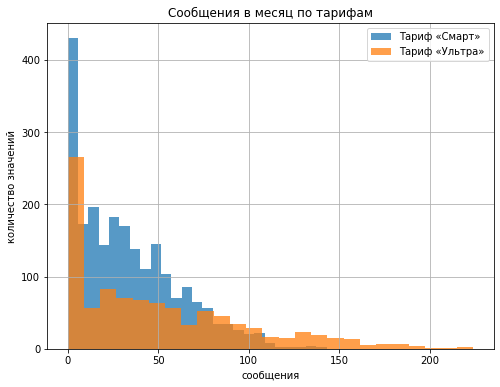

In [29]:
# Построим гистограмму
(
    df.query('tariff == "smart"')['messages']
    .hist(bins=25, alpha=0.75, figsize=(8, 6))
)
(
    df.query('tariff == "ultra"')['messages']
    .hist(bins=25, alpha=0.75, figsize=(8, 6))
)
plt.title('Сообщения в месяц по тарифам')
plt.xlabel('сообщения')
plt.ylabel('количество значений')
plt.legend(['Тариф «Смарт»', 'Тариф «Ультра»'])
plt.show()

In [30]:
# Посчитаем предельные значения по правилу трех сигм
print('Тариф «Смарт»:', 33 + 3 * 28)
print('Тариф «Ультра»:', 49 + 3 * 48)

Тариф «Смарт»: 117
Тариф «Ультра»: 193


Гистограмма напоминает распределение Пуассона. Для обоих тарифов характерно, что многие клиенты вообще не пользовались сообщениями.

Пользователям тарифа «Смарт» в среднем требуется 33 сообщения в месяц. 99% значений укладываются в 117 сообщений. При этом в тариф включено 50 сообщений. По гистограмме видно, что клиентам на этом тарифном плане часто приходится доплачивать за превышение пакета сообщений.

Пользователям тарифа «Ультра» в среднем требуется 49 сообщений в месяц. 99% значений укладываются в 193 сообщения. 1000 сообщений в тарифе с большим запасом хватит для всех клиентов.

#### Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [31]:
(
    df.groupby('tariff')
    .agg({'mb_used': ['mean', 'var', 'std']})
    .round()
)

mb_used                      
           mean          var      std
tariff                               
smart   16208.0   34462496.0   5870.0
ultra   19469.0  101751014.0  10087.0

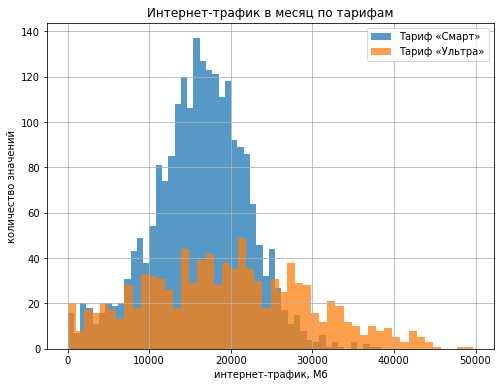

In [32]:
# Построим гистограмму
(
    df.query('tariff == "smart"')['mb_used']
    .hist(bins=50, alpha=0.75, figsize=(8, 6))
)
(
    df.query('tariff == "ultra"')['mb_used']
    .hist(bins=50, alpha=0.75, figsize=(8, 6))
)
plt.title('Интернет-трафик в месяц по тарифам')
plt.xlabel('интернет-трафик, Мб')
plt.ylabel('количество значений')
plt.legend(['Тариф «Смарт»', 'Тариф «Ультра»'])
plt.show()

In [33]:
# Посчитаем предельные значения по правилу трех сигм
print(f'Тариф «Смарт»: '
      f'{round((16208 + 3 * 5870) / 1024)}')
print(f'Тариф «Ультра»: '
      f'{round((19469 + 3 * 10087) / 1024)}')

Тариф «Смарт»: 33
Тариф «Ультра»: 49


Гистограммма тяготеет к нормальному распределению. Особенно это заметно для тарифа «Смарт», им пользуется большинство клиентов. Для тарифа «Ультра» заметен более длинный "хвост" значений, среднее значение и стандартное отклонение больше.

Пользователям тарифа «Смарт» в среднем требуется около 16 Гб интернет-трафика в месяц. 99% значений укладываются в 33 Гб. При этом в тариф включено всего 15 Гб. Половине клиентов на этом тарифном плане приходится доплачивать за превышение пакета интернет-трафика.

Пользователям тарифа «Ультра» в среднем требуется около 19 Гб интернет-трафика в месяц. 99% значений укладываются в 49 Гб. В тариф включено 30 Гб, чего не хватает значительному числу пользователей, что видно на гистограмме.

### Проверка гипотез

#### Средняя выручка пользователей тарифов «Смарт» и «Ультра» и  различаются

Сформулируем нулевую гипотезу: *Средняя выручка пользователей тарифов «Смарт» и «Ультра» равны*.

Сформулируем альтернативную гипотезу: *Средняя выручка пользователей тарифов «Смарт» и «Ультра» различаются*.

Определим критический уровень статистической значимости `alpha` в 0,1%. Чтобы принять или отвергнуть гипотезу, проведем статистический тест.

In [34]:
# Помесячная выручка от пользователей тарифа Смарт
tariff_smart_earnings = (
    df.query('tariff == "smart"')['earnings']
)

# Помесячная выручка от пользователей тарифа Ультра
tariff_ultra_earnings = (
    df.query('tariff == "ultra"')['earnings']
)

# Уровень статистической значимости
alpha = 0.001

# Статистический тест
results = st.ttest_ind(
    tariff_smart_earnings, tariff_ultra_earnings, equal_var=True
)

# Интерпретация результата
print('p-значение', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Принимаем альтернативную гипотезу. Средняя выручка пользователей тарифов «Смарт» и «Ультра» различаются. Полученное p-значение ничтожно мало, вероятность получить такую разницу в выручке случайно почти нулевая. Статистический тест не отвечает на вопрос, в какую сторону отличается выручка. Посчитаем средние значения.

In [35]:
# Получим средние значения выручки от пользователей тарифов
print(f'Средняя выручка от пользователей тарифа Смарт '
      f'{round(tariff_smart_earnings.mean(), 2)} руб./мес.')
print(f'Средняя выручка от пользователей тарифа Ультра '
      f'{round(tariff_ultra_earnings.mean(), 2)} руб./мес.')

Средняя выручка от пользователей тарифа Смарт 1289.97 руб./мес.
Средняя выручка от пользователей тарифа Ультра 2070.15 руб./мес.


Средняя выручка от пользователей тарифа «Смарт» меньше средней выручки от пользователей тарифа «Ультра».

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем нулевую гипотезу: *Средняя выручка пользователей из Москвы равна выручке от пользователей из других регионов*.

Сформулируем альтернативную гипотезу: *Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов*.

Определим критический уровень статистической значимости `alpha` в 0,1%. Чтобы принять или отвергнуть гипотезу, проведем статистический тест.

In [36]:
# Помесячная выручка от пользователей из Москвы
moscow_users_earnings = (
    df.query('city == "Москва"')['earnings']
)

# Помесячная выручка от пользователей из других регионов
regions_users_earnings = (
    df.query('city != "Москва"')['earnings']
)

# Уровень статистической значимости
alpha = 0.001

# Статистический тест
results = st.ttest_ind(
    moscow_users_earnings, regions_users_earnings, equal_var=True
)

# Интерпретация результата
print('p-значение', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Принимаем нулевую гипотезу. Средняя выручка пользователей из Москвы равна выручке от пользователей из других регионов. Полученное p-значение более 54%, вероятность получить разницу в выручке случайно очень высокая. Проверим, что средние значения выручки близки.

In [37]:
# Получим средние значения выручки
# от пользователей из Москвы и других регионов
print(f'Средняя выручка от пользователей из Москвы '
      f'{round(moscow_users_earnings.mean(), 2)} руб./мес.')
print(f'Средняя выручка от пользователей из других регионов '
      f'{round(regions_users_earnings.mean(), 2)} руб./мес.')

Средняя выручка от пользователей из Москвы 1546.71 руб./мес.
Средняя выручка от пользователей из других регионов 1524.94 руб./мес.


Средняя выручка пользователей из Москвы примерно равна выручке от пользователей из других регионов.

**Вывод**

В среднем пользователям тарифа «Смарт» в месяц требуется:
  * 418 минут разговора;
  * 33 сообщения;
  * около 16 Гб интернет-трафика.

Пользователям тарифа «Смарт» часто приходится доплачивать за превышение пакетов минут, сообщений и интернет-трафика.

В среднем пользователям тарифа «Ультра» в месяц требуется:
  * 527 минут разговора;
  * 49 сообщений;
  * около 19 Гб интернет-трафика.

Пользователям тарифа «Ультра» с запасом хватает пакетов минут и сообщений, но часто приходится доплачивать за превышение пакета интернет-трафика.

**Средняя выручка от пользователей тарифа «Смарт» меньше средней выручки от пользователей тарифа «Ультра»**. Несмотря на то, что пользователи этого тарифа чаще платят за превышение пакетов минут, сообщений и интернет-трафика, в выборе средний размер выручки от пользователей тарифа «Ультра» выше на 60%.

**Средняя выручка пользователей из Москвы примерно равна выручке от пользователей из других регионов**. Вероятно, это происходит из-за единых тарифов для всех регионов и похожих паттернов поведения пользователей.

## Общий вывод

По результатам исследования на выборке из 500 пользователей федерального оператора сотовой связи можно заключить, что **наиболее  перспективным тарифным планом для компании является «Ультра»**.

Пользователи на тарифном плане «Ультра» расходуют немного больше минут, сообщений и интернет-трафика, чем пользователи на тарифном плане «Смарт», но приносят на 60% больше дохода. Пакеты минут и сообщений в разы больше, чем требуется средним пользователям. Кроме того, часть пользователей регулярно доплачивает за превышение пакета интернет-трафика.

Пользователей тарифного плана «Смарт» можно мотивировать перейти на «Ультра» предложив большие пакеты минут и сообщений, исключающие необходимость доплачивать за превышение. Вместе с тем, возможно, стоит увеличить пакет интернет-трафика на тарифном плане «Ультра», чтобы предложение было более выгодным для клиентов компании.